# LASSO Regression

In this notebook, I take the raw water structure data and perform LASSO regression using hydration free energies, $\mu_{\nu}$, as labels.

## IMPORT MODULES

In [1]:
## MAKE MATPLOTLIB INLINE
%matplotlib inline

## IMPORT OS
import os

## IMPORT RANDOM
import random

## IMPORT NUMPY
import numpy as np  # Used to do math functions

## IMPORT PANDAS
import pandas as pd

## IMPORT REGRESSION FUNCTIONS FROM SKLEARN
from sklearn.linear_model import Lasso
from sklearn import metrics

## IMPORT GLOBAL INPUTS
from sam_analysis.ml_tools.globals import X_DATA_LIST, \
                                          TRAINING_GROUPS, TESTING_GROUPS, \
                                          NH2_GROUPS, CONH2_GROUPS, OH_GROUPS

## IMPORT DATA TOOLS
from sam_analysis.ml_tools.data_tools import rescale_data, \
                                             remove_correlated_features

## FUNCTION TO SAVE AND LOAD PICKLE FILES
from sam_analysis.core.pickles import load_pkl

## IMPORT CHECK SERVER PATH
from sam_analysis.core.check_tools import check_server_path

## IMPORT PLOTTING TOOLS
from sam_analysis.plotting.plots import plot_parity, plot_bar

## SET PATHS AND LOAD DATA
NOTE: "raw_regression_data.pkl" was converted into a pd.dataframe post analysis. Will need to change output of analysis to the data frame to facitate analysis and reproducibility.

In [2]:
## WORKING DIRECTORY
project_dir = r"/home/bdallin/python_projects/sam_analysis/sam_analysis"
data_dir    = "raw_data"

## DATA FILE
data_pkl = r"rescaled_uncorrelated_regression_data.pkl"

## FIGURE PATHS
manuscript_dir = r"/mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams"
fig_dir        = r"figures"
fig_name       = r"minimum_features"

## LOAD DATA
path_data_pkl = os.path.join( project_dir, data_dir, data_pkl )
raw_data      = load_pkl( path_data_pkl )

LOADING PKL FILE...
LOADED PKL FROM /home/bdallin/python_projects/sam_analysis/sam_analysis/raw_data/rescaled_uncorrelated_regression_data.pkl



## PERFORM K-FOLD CV

In [3]:
## CREATE PLACEHOLDERS
y_orig          = []
y_train_orig    = []
y_test_predict  = []
y_train_predict = []
weights         = []
rmse            = []
rmse_train      = []
colors          = []

## OPTIMAL HYPERPARAMETERS
alpha     = 2.4  # regularization constant
tol       = 1e-5 # lasso tolerance
max_iter  = 5000 # lasso maximum iteration, if tol not met

## LOOP THROUGH SAMPLES
for key, data in raw_data.items():
    ## SPLIT TO X AND Y DATA 
    X = data.drop( "hfe_mu", axis = 1 )
    y = data["hfe_mu"]
    
    ## GENERATE EMPTY Y PREDICTION ARRAY
    yo  = np.empty( shape = ( 0, ) )
    yot = np.empty( shape = ( 0, ) )
    yp  = np.empty( shape = ( 0, ) )
    yt  = np.empty( shape = ( 0, ) )

    ## GENERATE EMPTY COEFS ARRAY
    rc = np.empty( shape = ( 0, X.shape[1] ) )

    for nn in range( len(TRAINING_GROUPS) ):        
        ## TRAINING DATA
        X_train = X.iloc[ TRAINING_GROUPS[nn], : ]
        y_train = y.iloc[ TRAINING_GROUPS[nn] ]

        ## TEST DATA
        X_test   = X.iloc[ TESTING_GROUPS[nn], : ]
        y_test   = y.iloc[ TESTING_GROUPS[nn] ]

        ## INITIALIZE LASSO
        regressor = Lasso( alpha    = alpha, 
                           tol      = tol, 
                           max_iter = max_iter )

        ## TRAIN LINEAR REGRESSION MODEL ON TRAINING DATA
        regressor.fit( X_train, y_train )

        ## UPDATE PREDICT Y TRAIN
        yt  = np.hstack(( yt, regressor.predict( X_train ) ))

        ## UPDATE PREDICT Y TEST
        yp  = np.hstack(( yp, regressor.predict( X_test ) ))

        ## UPDATE ORIG ARRAY
        yo  = np.hstack(( yo, y_test ))
        yot = np.hstack(( yot, y_train ))

        ## UPDATE COEFS ARRAY
        rc = np.vstack(( rc, regressor.coef_ ))
        
        ## UPDATE COLOR LIST
        for gg in TESTING_GROUPS[nn]:
            if gg in NH2_GROUPS and gg != 0:
                colors.append( "slateblue" )
            if gg in CONH2_GROUPS and gg != 0:
                colors.append( "darkseagreen" )
            if gg in OH_GROUPS and gg != 0:
                colors.append( "tomato" )
            if gg == 0:
                colors.append( "darkgrey" )

    ## COMPUTE MSE & RMSE
    MSE        = metrics.mean_squared_error( yo, yp )
    RMSE       = np.sqrt( MSE )
    MSE_TRAIN  = metrics.mean_squared_error( yot, yt )
    RMSE_TRAIN = np.sqrt( MSE_TRAIN )

    ## UPDATE LISTS
    y_orig.append( yo )
    y_train_orig.append( yot )
    y_test_predict.append( yp )
    y_train_predict.append( yt )
    weights.append( pd.DataFrame( rc, columns = X.columns.values ) )
    rmse.append( RMSE )
    rmse_train.append( RMSE_TRAIN )

## COMPUTE STATISTICS
y_indus           = np.mean( y_orig, axis = 0 )
y_indus_err       = np.std( y_orig, axis = 0 )
y_train_indus     = np.mean( y_train_orig, axis = 0 )
y_train_indus_err = np.std( y_train_orig, axis = 0 )
y_pred            = np.mean( y_test_predict, axis = 0 )
y_pred_err        = np.std( y_test_predict, axis = 0 )
y_train_pred      = np.mean( y_train_predict, axis = 0 )
y_train_pred_err  = np.std( y_train_predict, axis = 0 )
rmse_err          = np.std( rmse )
rmse              = np.mean( rmse )
rmse_train_err    = np.std( rmse_train )
rmse_train        = np.mean( rmse_train )
## COMBINE WEIGHTS
tmp         = pd.concat([ ww for ww in weights ])
coefs       = tmp.groupby( level = 0 ).mean()
coefs_err   = tmp.groupby( level = 0 ).std()
## SET NANS TO ZERO
coefs[ np.isnan(coefs) ] = 0.
coefs_err[ np.isnan(coefs_err) ] = 0.
## COMPUTE WEIGHT STATISTICS
weights     = np.mean( coefs, axis = 0 ) 
weights_err = np.std( coefs, axis = 0 )

## PLOT PARITY


--- CREATING PARITY PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_parity_minimum_features


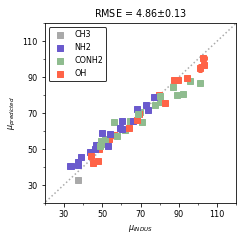

In [4]:
## PLOT PARITY
fig_path = os.path.join( manuscript_dir, fig_dir, "k_fold_lasso_parity_{}".format( fig_name ) )
plot_parity( y_indus, y_pred,
             xerr     = y_indus_err,
             yerr     = y_pred_err,
             title    = r"RMSE = {:.2f}$\pm${:.2f}".format( rmse, rmse_err ),
             xlabel   = r"$\mu_{INDUS}$",
             ylabel   = r"$\mu_{predicted}$",
             xticks   = [ 30, 110, 20 ],
             yticks   = [ 30, 110, 20 ],
             colors   = colors,
             legend   = [ [ "darkgrey", "slateblue", "darkseagreen", "tomato" ],
                          [ "CH3", "NH2", "CONH2", "OH" ] ],
             fig_path = fig_path, )

## PLOTTING FEATURE WEIGHTS


--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_weights_minimum_features_0

--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_weights_minimum_features_1

--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_weights_minimum_features_2

--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_weights_minimum_features_3

--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_lasso_weights_minimum_features_4


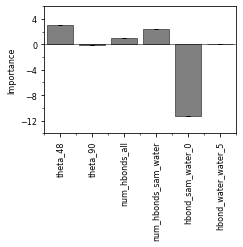

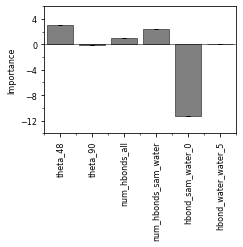

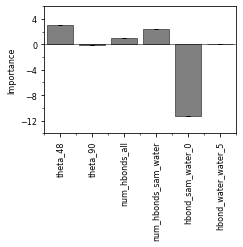

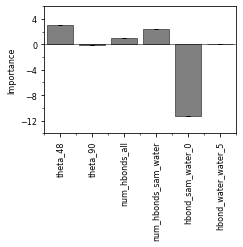

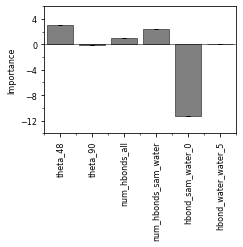

In [5]:
## PLOT SALIENCY
zero_weights  = np.abs(weights) > 0.0001
zero_features = weights.index.values[zero_weights]

## LOOP THROUGH FOLDS
for ff in range(len(coefs)):
    ## DROP ZERO FEATURES
    cc = coefs.iloc[0][zero_features]
    fig_path = os.path.join( manuscript_dir, fig_dir, "k_fold_lasso_weights_{}_{}".format( fig_name, ff ) )
    plot_bar( [ np.arange( 0, len(cc), 1 ) ],
              [ cc ], 
#               yerr     = [ coefs_err.mean( axis = 0 ) ],
              xlabel   = list(cc.index.values),
              ylabel   = r"Importance",
              yticks   = [  -12,  4,  4 ],
              colors   = [ "grey" ],
              fig_path = fig_path )